In [1]:
from ClassiPyGRB import SWIFT
# Packages needed for this notebook
import os
import numpy as np

In [2]:
import torch
import torch.nn as nn
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

In [3]:
%matplotlib inline
swift = SWIFT(root_path=r'data', res=64, n_bands=[1,2,3,4,5])
print(f"Swift/BAT bands selected: {swift.bands_selected}")

Swift/BAT bands selected: ['Time(s)', '15-25keV', '25-50keV', '50-100keV', '100-350keV', '15-350keV']


In [4]:
data_loaded = np.load(os.path.join(swift.results_path, f'SWIFT_data_{swift.res}res_{"".join(str(b) for b in swift.n_bands)}bands_DFT_True.npz'))
grb_names, features = data_loaded['names'], data_loaded['data']
durations = swift.total_durations(grb_names, t=90)

Finding Durations: 100%|██████████████████| 1502/1502 [00:10<00:00, 146.96GRB/s]


In [5]:
data_loaded_plain = np.load(os.path.join(swift.results_path, f'SWIFT_data_{swift.res}res_{"".join(str(b) for b in swift.n_bands)}bands_DFT_False.npz'))
grb_names, features_plain = data_loaded_plain['names'], data_loaded_plain['data']

In [6]:
features.shape

(1502, 48000)

In [7]:
features[0]

array([3.27826857e-04, 8.94158557e-05, 1.61230386e-04, ...,
       5.67102445e-06, 5.72234663e-06, 2.96175636e-06])

In [8]:
features_plain.shape

(1502, 96000)

In [9]:
features_plain[0]

array([0.03530691, 0.02169923, 0.04108426, ..., 0.        , 0.        ,
       0.        ])

In [10]:
l = int(data_loaded_plain['data'].shape[1]*4/5)

In [11]:
features_plain = data_loaded_plain['data'][:,l:]

In [12]:
features_plain.shape

(1502, 19200)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


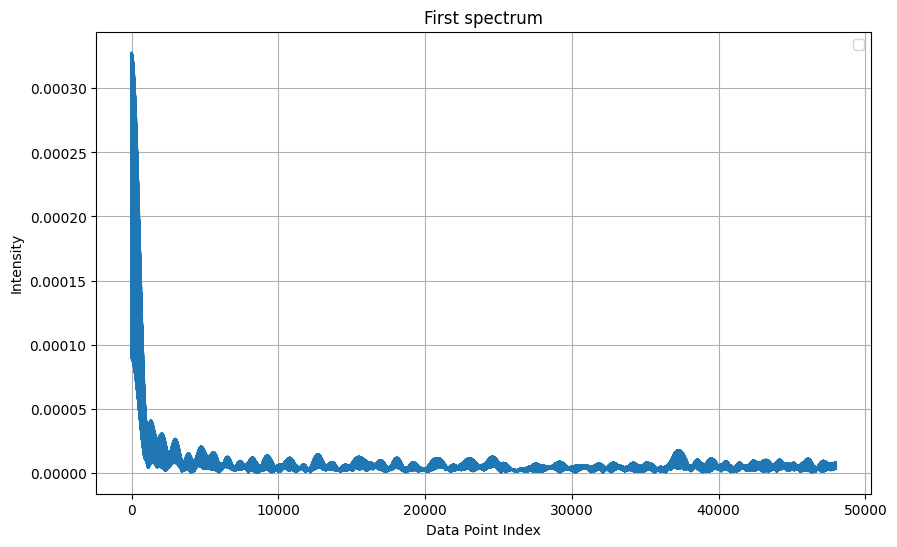

In [13]:
x = np.linspace(0, features.shape[1], features.shape[1])  # Simulated x-axis values for the spectrum

plt.figure(figsize=(10, 6))
plt.plot(x, features[0])
plt.title('First spectrum')
plt.xlabel('Data Point Index')
plt.ylabel('Intensity')
plt.legend()
plt.grid(True)
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


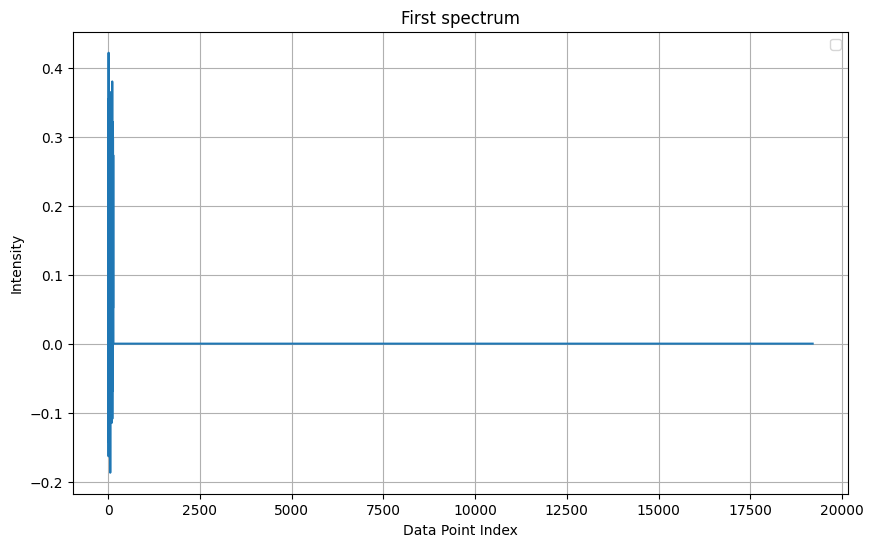

In [14]:
x = np.linspace(0, features_plain.shape[1], features_plain.shape[1])  # Simulated x-axis values for the spectrum

plt.figure(figsize=(10, 6))
plt.plot(x, features_plain[5])
plt.title('First spectrum')
plt.xlabel('Data Point Index')
plt.ylabel('Intensity')
plt.legend()
plt.grid(True)
plt.show()

In [15]:
print(np.mean(features,axis=1))
print(np.std(features,axis=1))

[7.08391325e-06 7.00145636e-06 1.31297856e-05 ... 3.74117762e-06
 2.49947029e-05 1.91853215e-05]
[1.80608751e-05 1.44879182e-05 2.11228685e-05 ... 8.77317851e-06
 2.76920412e-05 1.42807089e-05]


In [16]:
# Normalize the features here
normalized_features = (features - np.mean(features, axis=1, keepdims=1))/np.std(features,axis=1,keepdims=1)
print(normalized_features.shape)
print(np.mean(normalized_features,axis=1))
print(np.std(normalized_features,axis=1))

(1502, 48000)
[ 3.31586610e-17  9.94759830e-17  4.73695157e-18 ...  2.36847579e-17
 -4.50010399e-17  1.51582450e-16]
[1. 1. 1. ... 1. 1. 1.]


In [17]:
_normalized_features = normalized_features # copy this so rerunning next cell doesn't throw error
_labels = np.zeros(shape=(normalized_features.shape[0],1))

In [18]:
normalized_features = torch.from_numpy(_normalized_features).to(torch.float32)
labels = torch.from_numpy(_labels).to(torch.float32)

X_train, X_test, class_train, class_test = train_test_split(normalized_features, labels, test_size=0.2, random_state=205)

training_dataset = TensorDataset(X_train, class_train)
test_dataset = TensorDataset(X_test, class_test)

BATCHSIZE = 128
BATCHSIZE_TEST = 256

train_dataloader = DataLoader(training_dataset, batch_size=BATCHSIZE, shuffle=True)
test_dataloader  = DataLoader(test_dataset, batch_size=BATCHSIZE_TEST, shuffle=True)

In [19]:
INPUT_SIZE      = features.shape[1]
LATENT_SIZE     = 5
HIDDEN_SIZE     = 100

In [20]:
# Note that this code is largely from https://github.com/LSSTC-DSFP/LSSTC-DSFP-Sessions/tree/main/Sessions/Session14
# First, we will inherit from pytorch Module class; https://pytorch.org/docs/stable/generated/torch.nn.Module.html

class Encoder(nn.Module):
    def __init__(self, seed=205):
        """
        seed: int, random seed for reproducibility
        """
        super(Encoder, self).__init__()
        self.seed = torch.manual_seed(seed)
        # here we are initializing the linear layers. This registeres the layer parameters (W,b) as parameters of the Module
        self.fc1 = nn.Linear(INPUT_SIZE,HIDDEN_SIZE)
        self.fc2 = nn.Linear(HIDDEN_SIZE,LATENT_SIZE)

        # We will initialize weights following a multivariate Gaussian
        nn.init.normal_(self.fc1.weight, mean=0, std=0.01)
        nn.init.normal_(self.fc1.bias, mean=0, std=0.01)
        nn.init.normal_(self.fc2.weight, mean=0, std=0.01)
        nn.init.normal_(self.fc2.bias, mean=0, std=0.01)

    # this defines a forward pass of the network (="applying" the network to some input data)
    def forward(self, x):
        # print(x.dtype)
        # print(self.fc1.weight.dtype)
        # print(self.fc1.bias.dtype) # for debugging dtype mismatch
        x      = torch.nn.LeakyReLU()(self.fc1(x))
        z      = self.fc2(x)
        return z

class Decoder(nn.Module):
    def __init__(self, seed=205):
        """
        seed: int, random seed for reproducibility
        """
        super(Decoder, self).__init__()
        self.seed = torch.manual_seed(seed)
        # Using the encoder, how will you initialize two layers?
        self.fc1 = nn.Linear(LATENT_SIZE,HIDDEN_SIZE)
        self.fc2 = nn.Linear(HIDDEN_SIZE,INPUT_SIZE)

        # Using the endoer, how will you initialize the weights and biases?
        nn.init.normal_(self.fc1.weight, mean=0, std=0.01)
        nn.init.normal_(self.fc1.bias, mean=0, std=0.01)
        nn.init.normal_(self.fc2.weight, mean=0, std=0.01)
        nn.init.normal_(self.fc2.bias, mean=0, std=0.01)

    def forward(self, z):
        # Using the encoder, how will you define the forward pass?
        # I recommend the same activation function!
        z      = torch.nn.LeakyReLU()(self.fc1(z))
        x      = self.fc2(z)
        return x

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # here we are creating instances of the Encoder and Decoder class
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        z = self.encoder(x)
        x = self.decoder(z)
        return x

In [21]:
# This creates an instance of the Autoencoder class
AE = Autoencoder()

In [22]:
# the training loop takes a function that loads the data batch by batch, a model to train, a loss function to train the model on and an optimizer
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    losses = []
    # iterate over the dataset
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction of the model
        pred = model(X)
        # Compute the loss function
        loss = loss_fn(pred,X)

        # Backpropagation; this is where we take the gradient and update the network parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # here we keep track of the loss
        if batch % 10 == 0:
            loss, current = loss.item(), batch * len(X)
            losses.append(loss)
            print(f"train loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

    return losses

# the test loop is similar to the training loop, only that we don't take any gradients/don't update the network parameters, but only evaluate
def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss =  0
    with torch.no_grad():
        for (X, y) in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, X).item()

    test_loss /= num_batches
    print(f" Avg test loss: {test_loss:>8f} \n")

    return test_loss

In [23]:
EPOCHS = 200
LEARNING_RATE = 1e-3


# MeanSquaredError (L2) Loss
loss_fn         = nn.MSELoss()
# Adam Optimizer
optimizer       = torch.optim.Adam(AE.parameters(), lr=LEARNING_RATE)


train_loss = []
test_loss  = []
for t in range(EPOCHS):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss.append(train_loop(train_dataloader, AE, loss_fn, optimizer))
    test_loss.append(test_loop(test_dataloader, AE, loss_fn))
print("Done!")

Epoch 1
-------------------------------
train loss: 1.000065  [    0/ 1201]
 Avg test loss: 0.845764 

Epoch 2
-------------------------------
train loss: 0.853760  [    0/ 1201]
 Avg test loss: 0.689739 

Epoch 3
-------------------------------
train loss: 0.705719  [    0/ 1201]
 Avg test loss: 0.568709 

Epoch 4
-------------------------------
train loss: 0.553434  [    0/ 1201]
 Avg test loss: 0.523736 

Epoch 5
-------------------------------
train loss: 0.500221  [    0/ 1201]
 Avg test loss: 0.486654 

Epoch 6
-------------------------------
train loss: 0.480343  [    0/ 1201]
 Avg test loss: 0.443949 

Epoch 7
-------------------------------
train loss: 0.480909  [    0/ 1201]
 Avg test loss: 0.411922 

Epoch 8
-------------------------------
train loss: 0.389201  [    0/ 1201]
 Avg test loss: 0.402398 

Epoch 9
-------------------------------
train loss: 0.345214  [    0/ 1201]
 Avg test loss: 0.370324 

Epoch 10
-------------------------------
train loss: 0.359383  [    0/ 12

In [24]:
plot_train_loss = [x[-1] for x in train_loss]

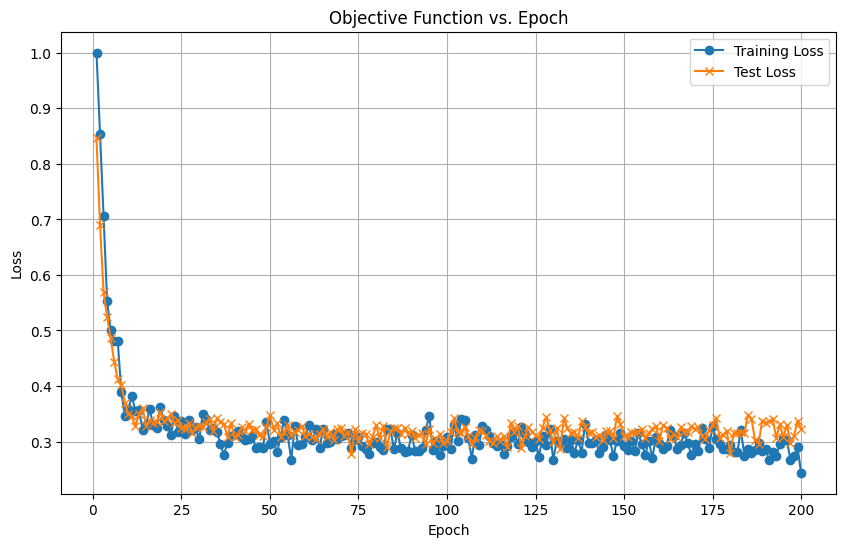

In [25]:
epochs = range(1, len(train_loss) + 1)  # Epochs are 1-based indexing

plt.figure(figsize=(10, 6))
plt.plot(epochs, plot_train_loss, label='Training Loss', marker='o')
plt.plot(epochs, test_loss, label='Test Loss', marker='x')
plt.title('Objective Function vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

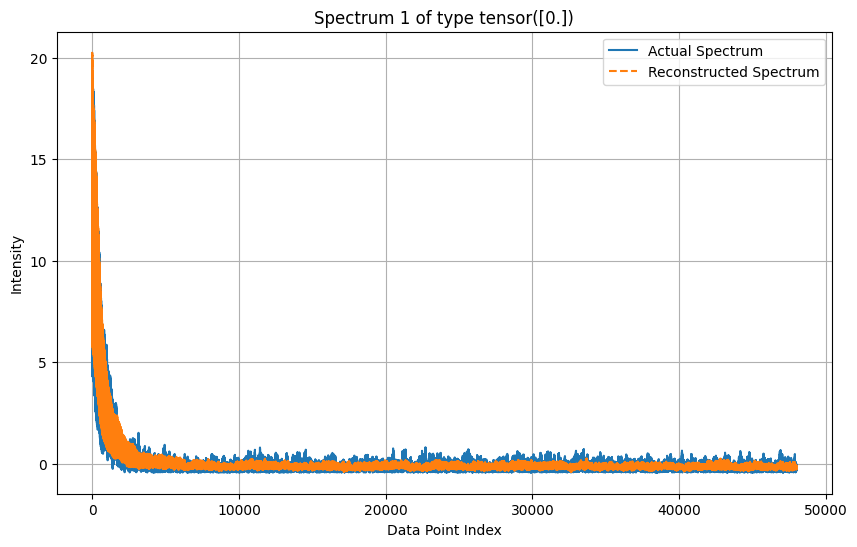

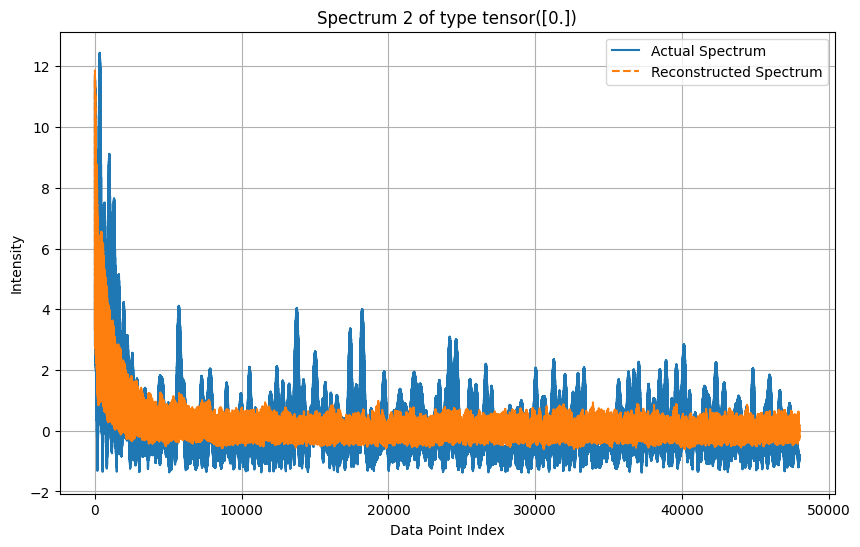

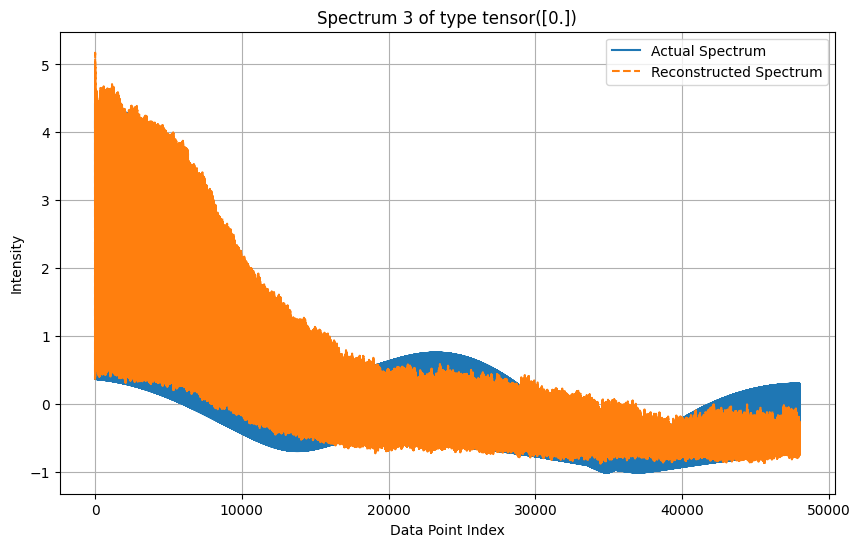

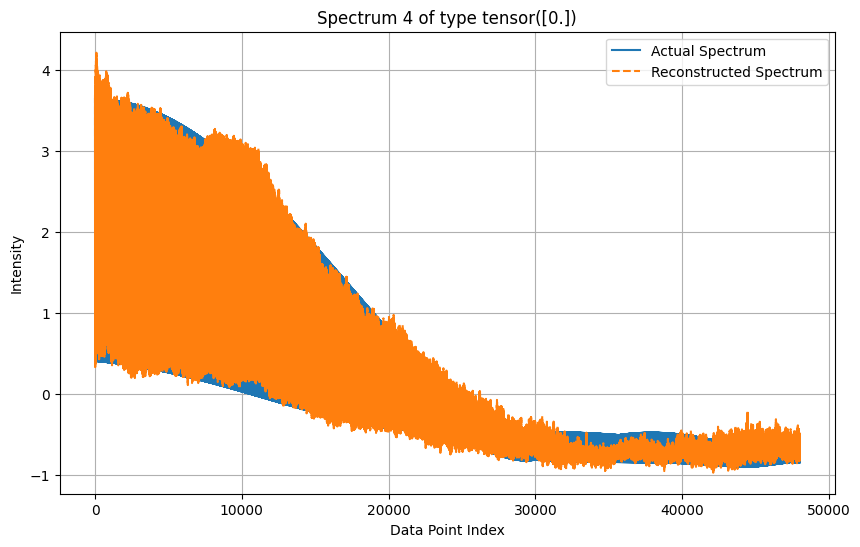

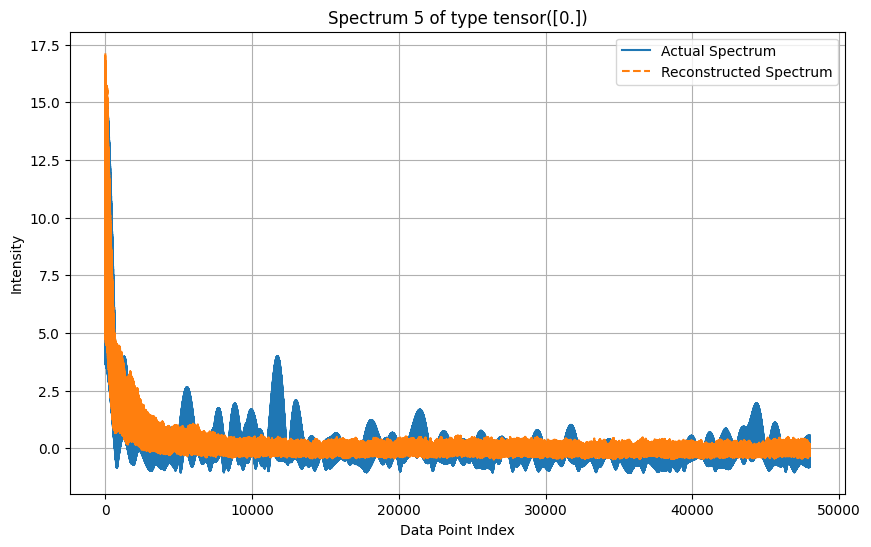

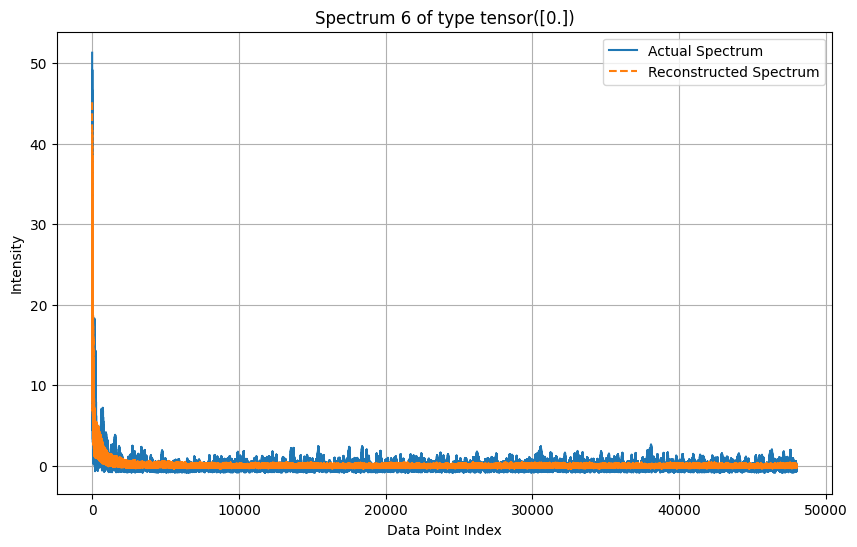

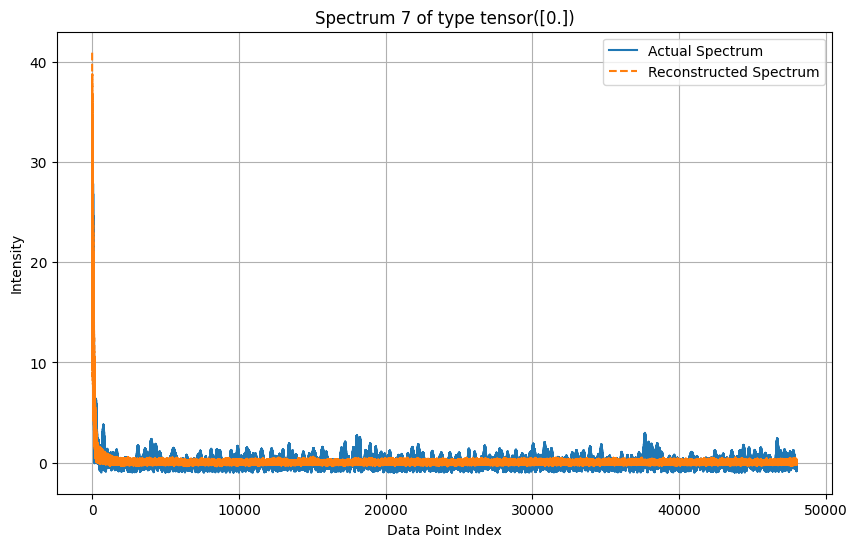

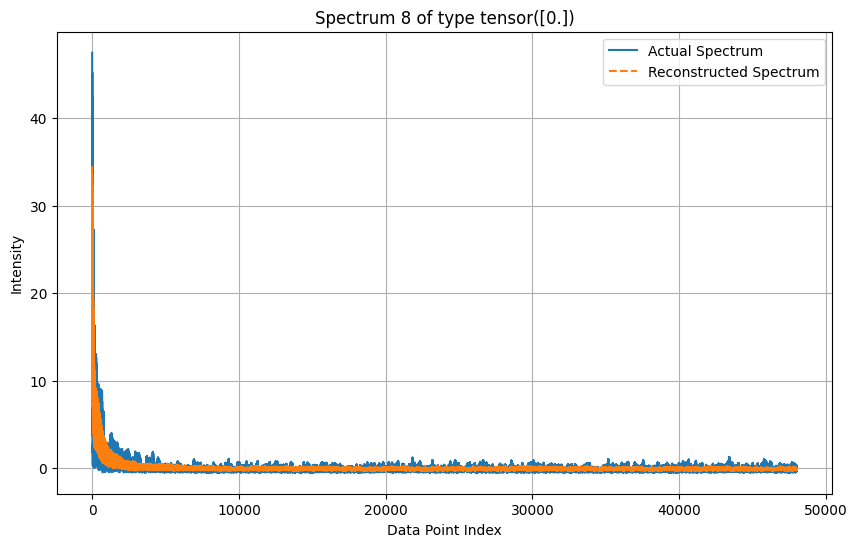

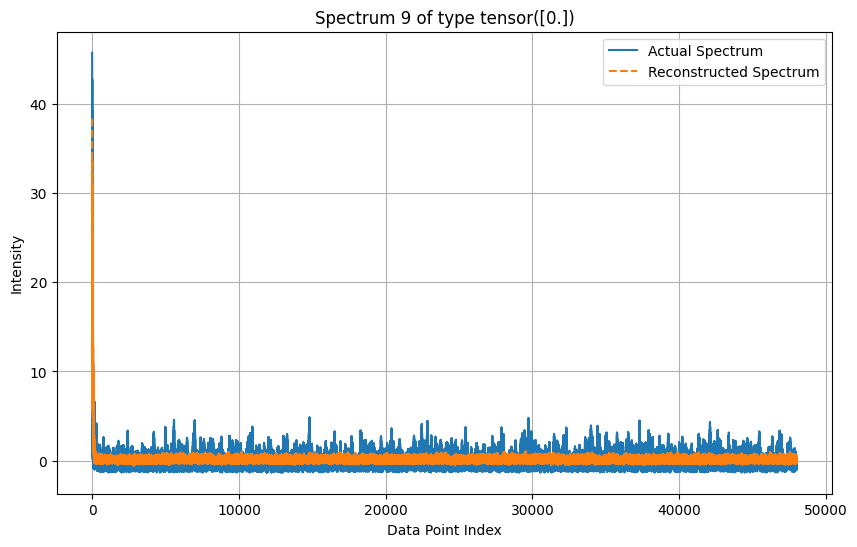

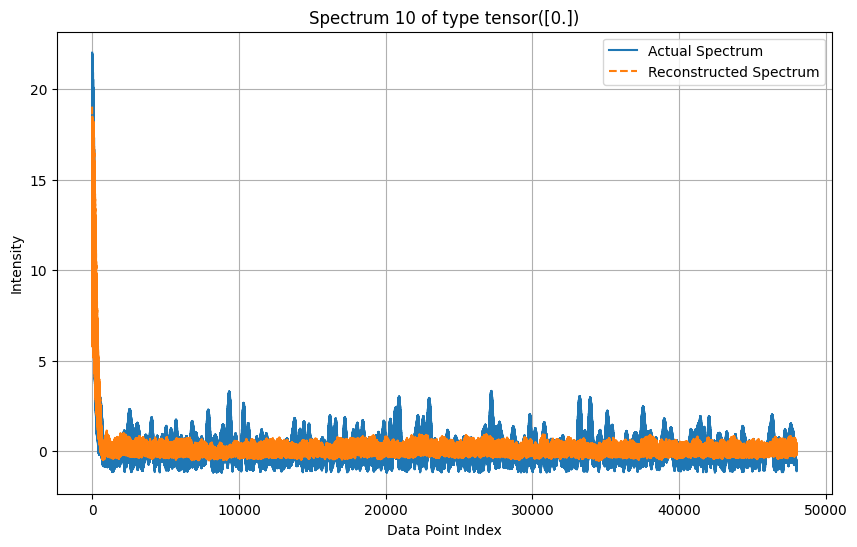

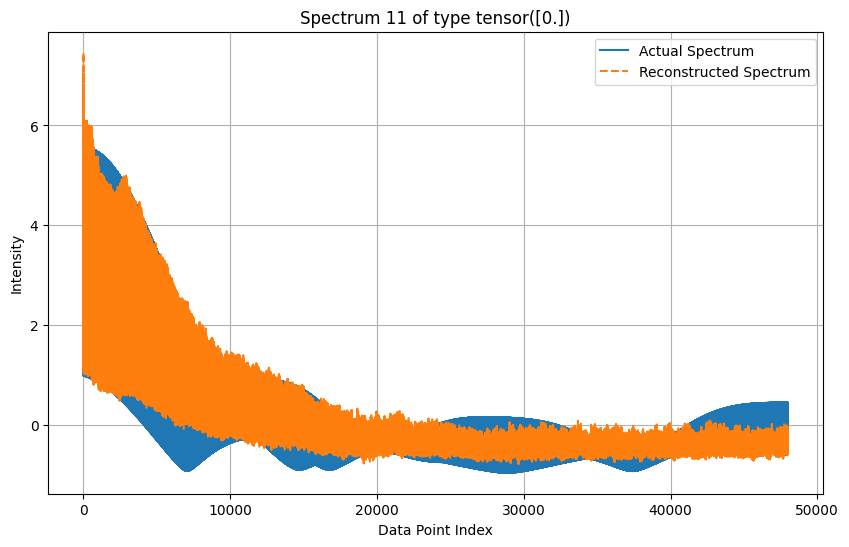

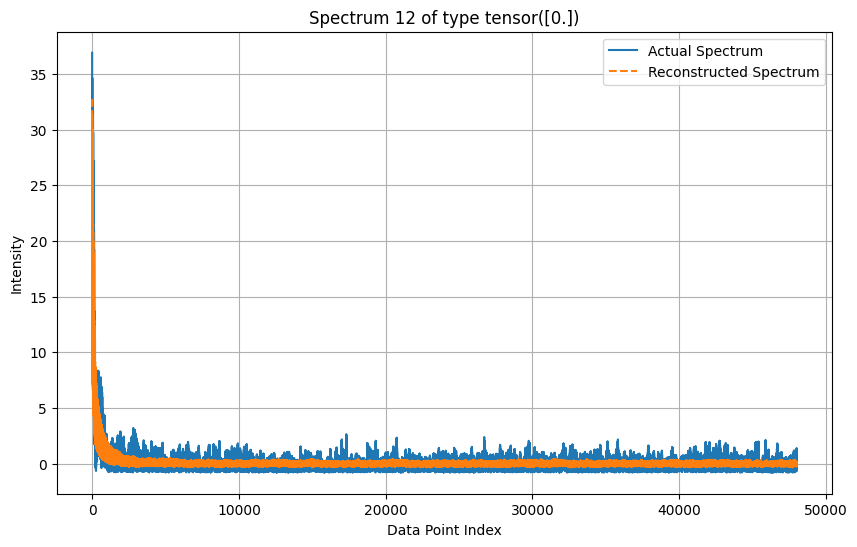

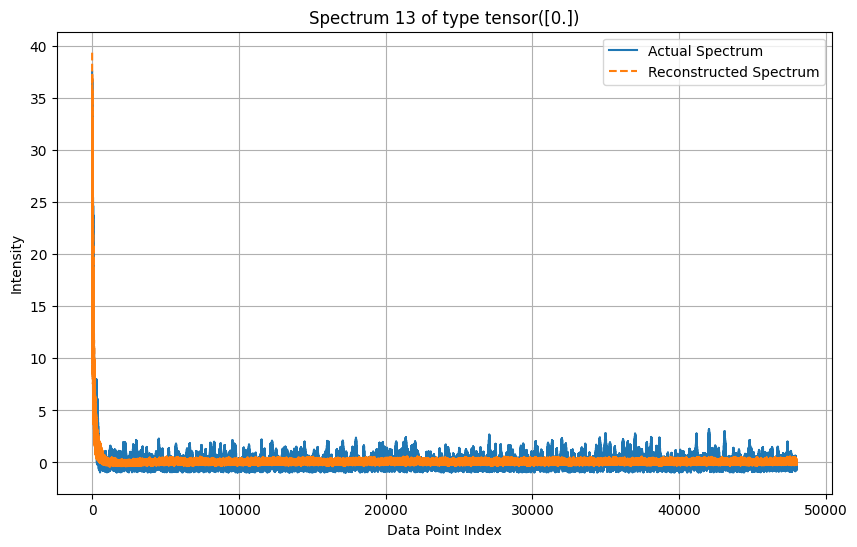

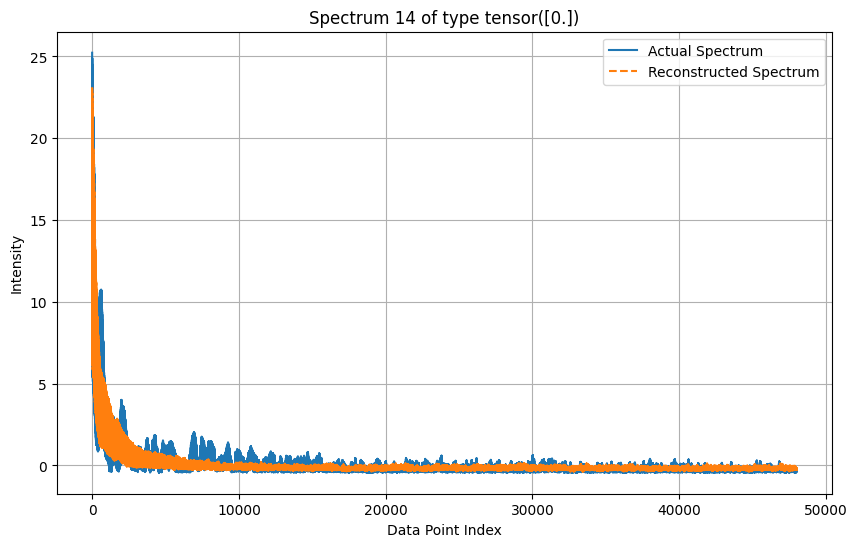

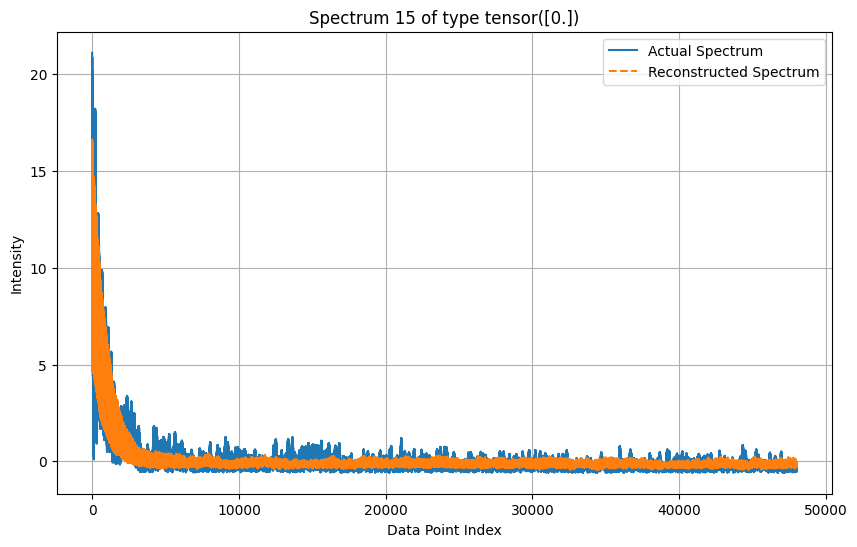

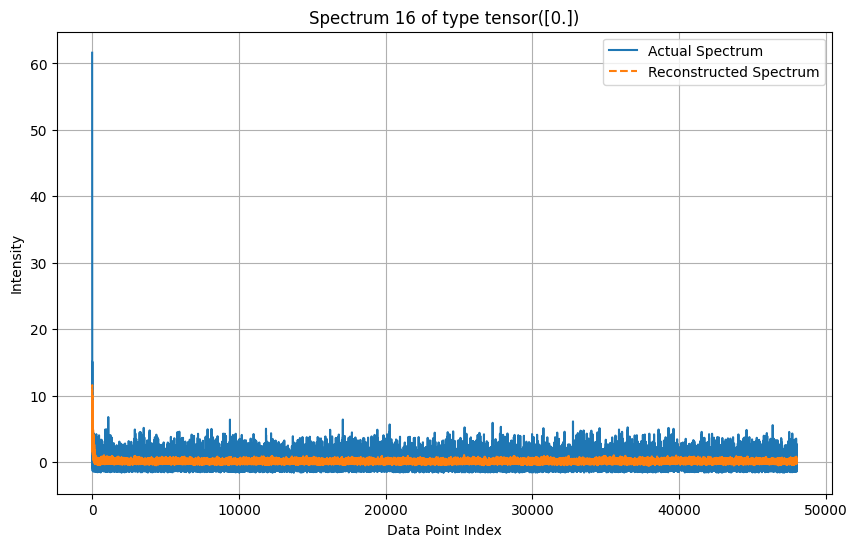

In [26]:
vis_loader = DataLoader(test_dataset, batch_size=16, shuffle=True) # get 16 random spectra

for X_batch, y_batch in vis_loader:
    # Simulated x-axis values for the spectrum
    x = np.linspace(0, features.shape[1], features.shape[1])
    
    with torch.no_grad():
        preds = AE(X_batch).detach()
    
    for i in range(len(X_batch)):
        plt.figure(figsize=(10, 6))
        plt.plot(x, X_batch[i].numpy(), label='Actual Spectrum')  # Converting tensor to numpy array for plotting
        plt.plot(x, preds[i].numpy(), label='Reconstructed Spectrum',linestyle='--')
        plt.title(f'Spectrum {i+1} of type {y_batch[i]}')
        plt.xlabel('Data Point Index')
        plt.ylabel('Intensity')
        plt.legend()
        plt.grid(True)
    break # just need one batch of 16

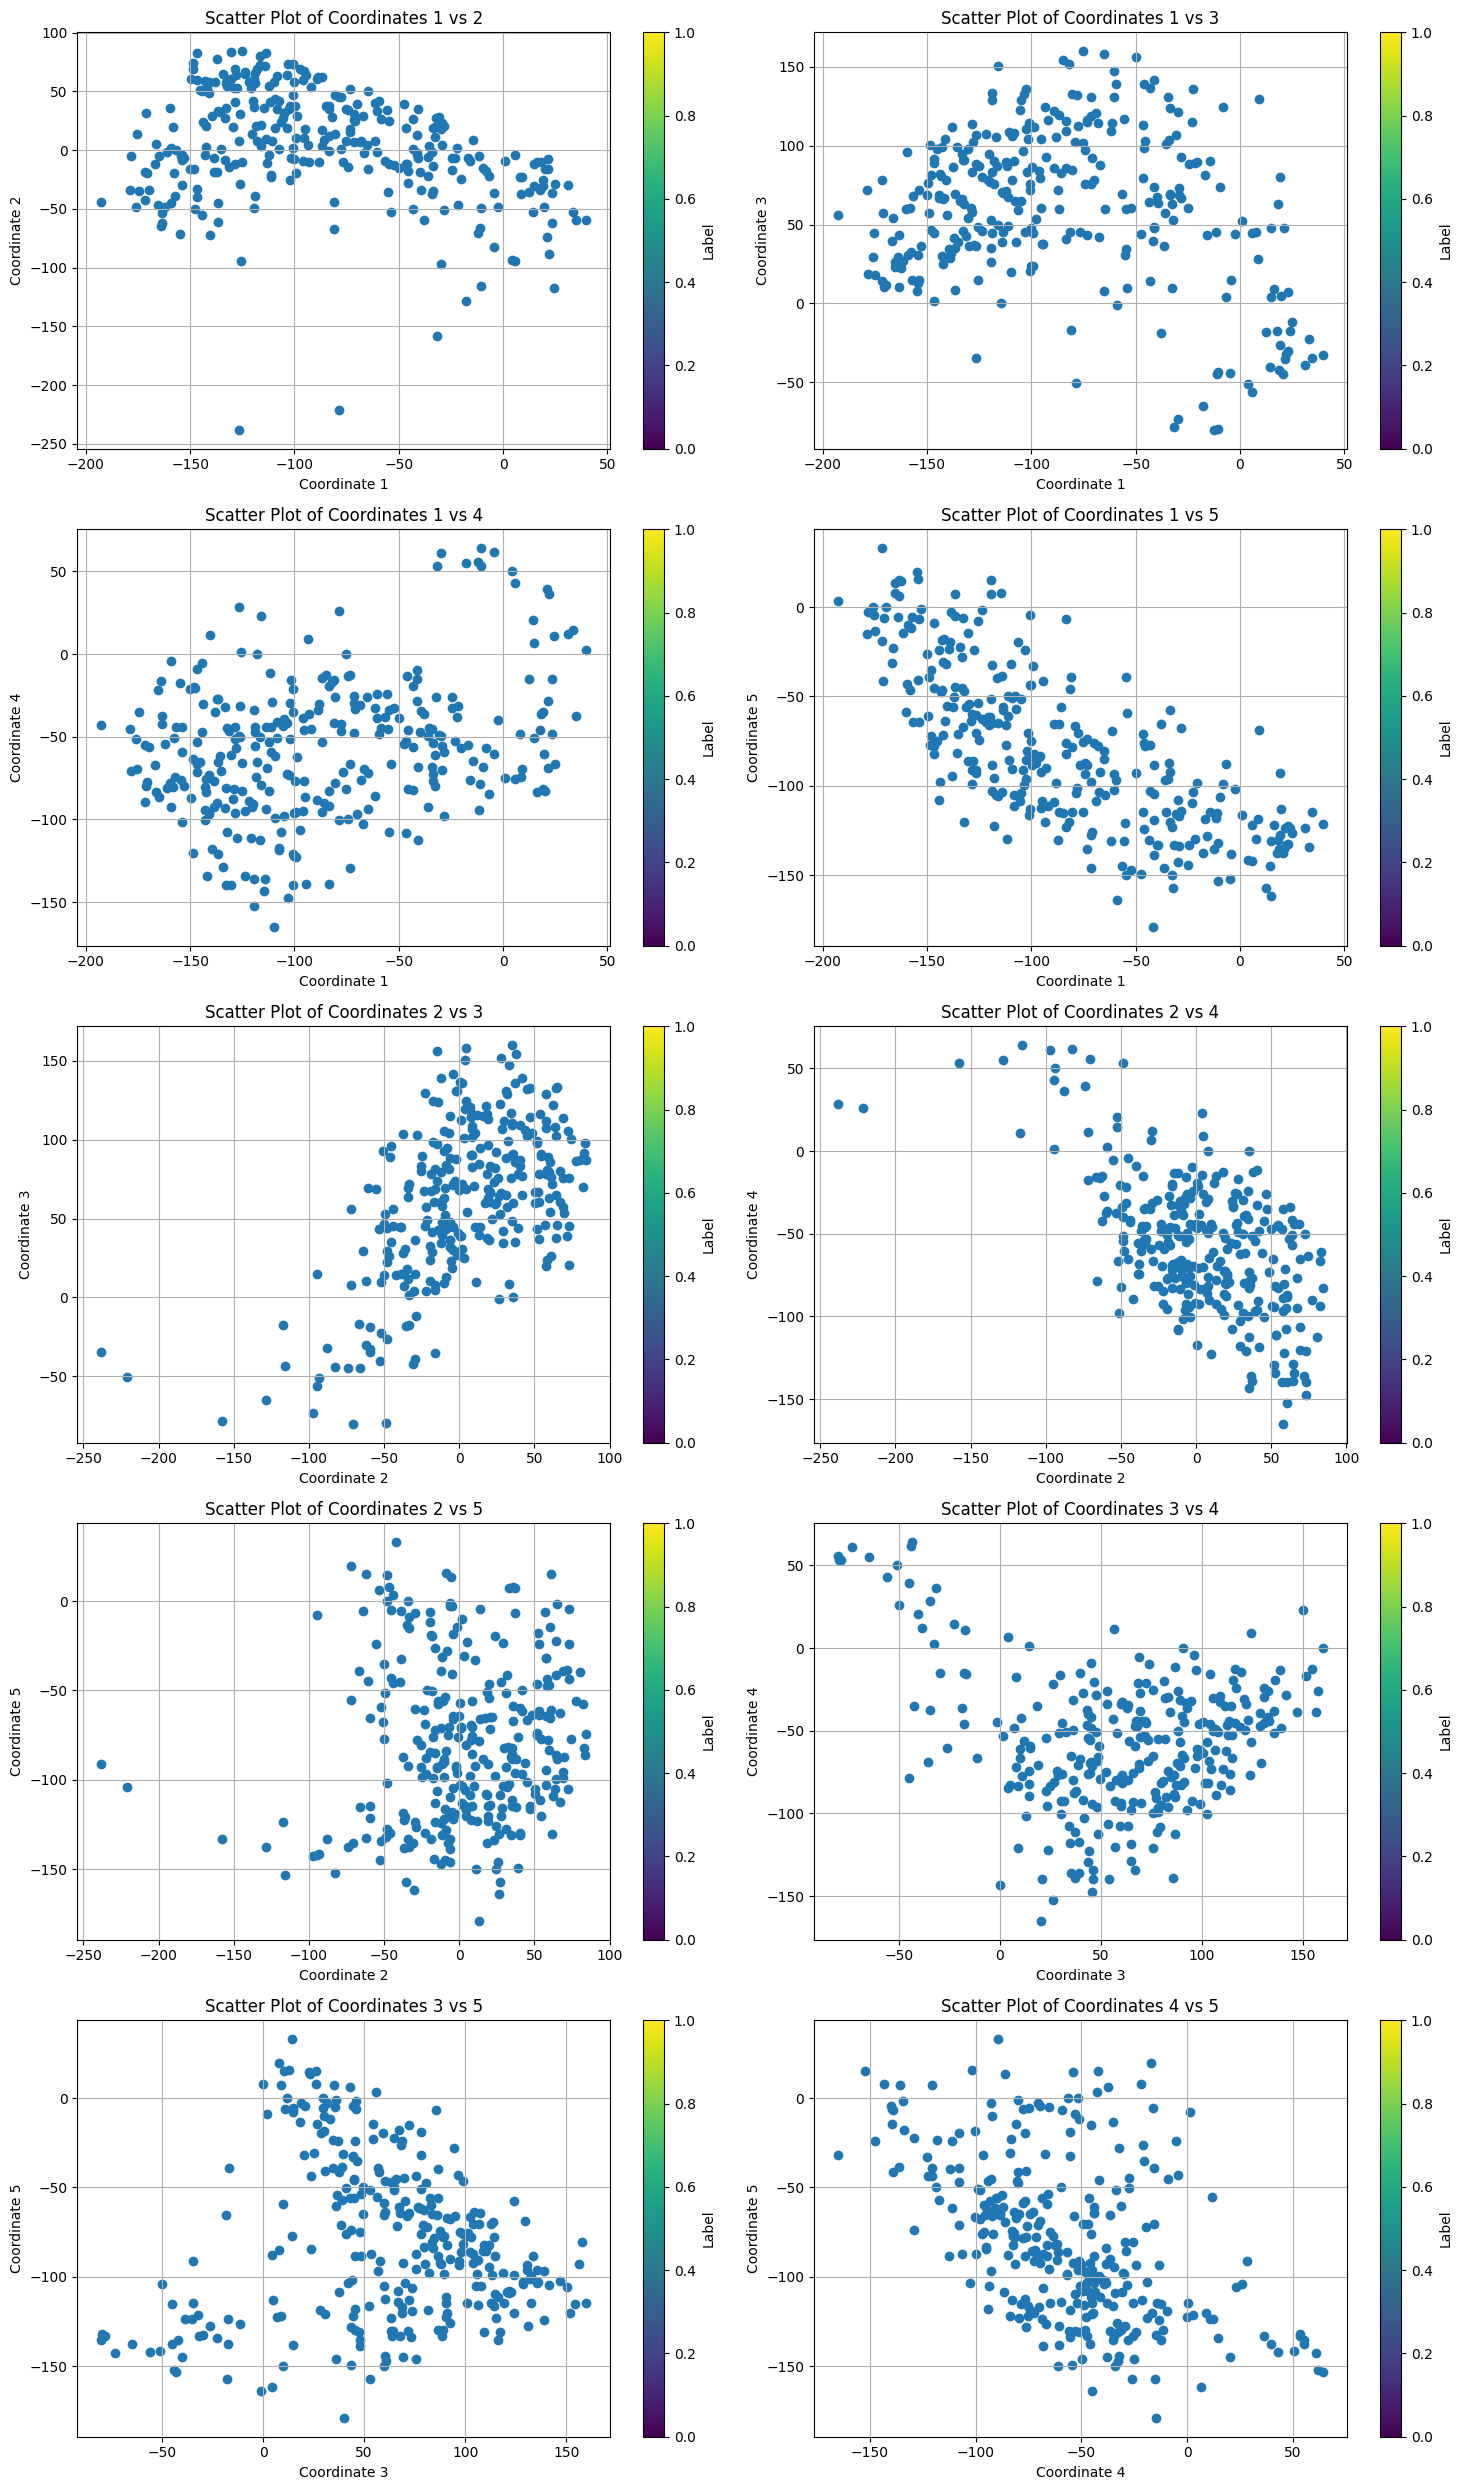

In [27]:
preds = []
labls = []
for X_batch, y_batch in test_dataloader:
    with torch.no_grad():
        preds.append(AE.encoder(X_batch).detach())
        labls += y_batch

preds = torch.cat(preds)

import itertools

# Assuming `preds` is your 5-dimensional encoded tensor
# Example: preds = torch.randn(100, 5)  # Random data for illustration

# Generate all combinations of the 5 coordinates taken 2 at a time
combos = list(itertools.combinations(range(5), 2))

# Create plots for all combinations
fig, axs = plt.subplots(5, 2, figsize=(15, 25))  # Adjust subplot grid as needed

for i, (idx1, idx2) in enumerate(combos):
    ax = axs[i//2, i%2]  # Determine the subplot for the current combo
    scatter = ax.scatter(preds[:, idx1].numpy(), preds[:, idx2].numpy())
    ax.set_title(f'Scatter Plot of Coordinates {idx1+1} vs {idx2+1}')
    ax.set_xlabel(f'Coordinate {idx1+1}')
    ax.set_ylabel(f'Coordinate {idx2+1}')
    ax.grid(True)

    cbar = fig.colorbar(scatter, ax=ax)
    cbar.set_label('Label')

plt.tight_layout()
plt.show()

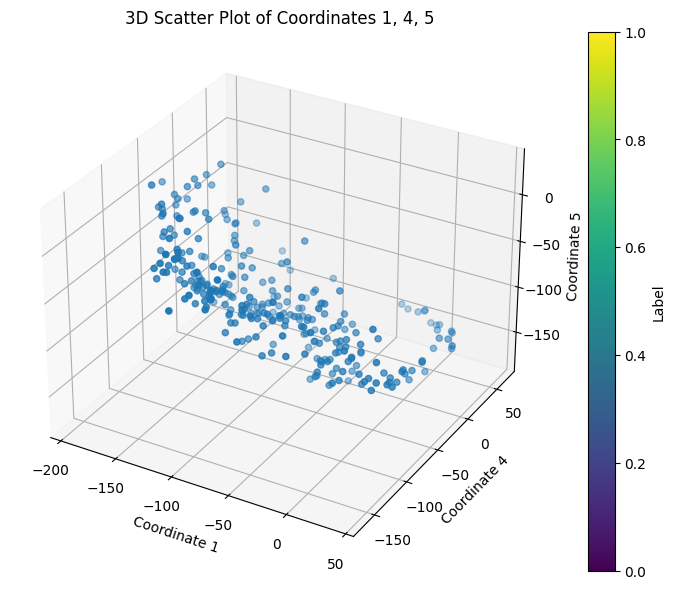

In [28]:
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Create a scatter plot
scatter = ax.scatter(preds[:, 0].numpy(), preds[:, 3].numpy(), preds[:, 4].numpy())

# Add labels and title
ax.set_xlabel('Coordinate 1')
ax.set_ylabel('Coordinate 4')
ax.set_zlabel('Coordinate 5')
ax.set_title('3D Scatter Plot of Coordinates 1, 4, 5')

# Add a color bar
cbar = fig.colorbar(scatter, ax=ax)
cbar.set_label('Label')

plt.show()

In [29]:
preds_=preds

In [30]:
from sklearn.cluster import KMeans

encoded = preds_
kmeans = KMeans(n_clusters=2, random_state=205).fit(encoded)
kmeans

KMeans(n_clusters=2, random_state=205)

In [31]:
print(kmeans.cluster_centers_)

[[ -16.25825701  -33.11685561   26.34074808  -33.97778988 -122.63856988]
 [-114.32566182   17.03065183   74.79063011  -66.50503855  -62.30232189]]


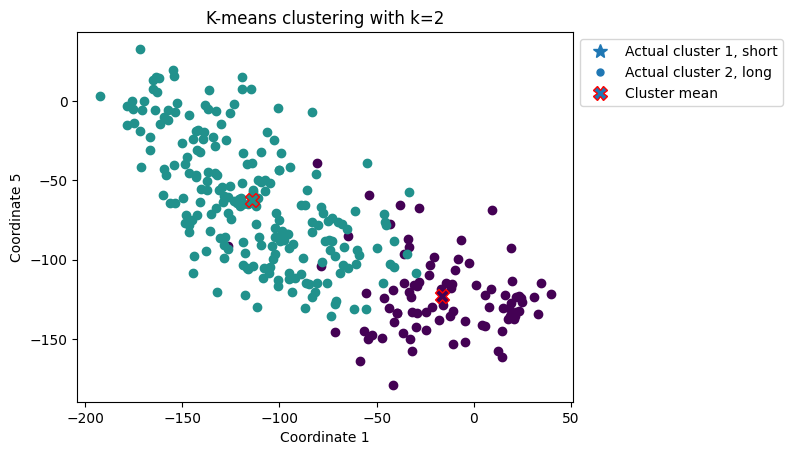

In [32]:
from matplotlib.lines import Line2D      

ax = plt.subplot(1,1,1)
labls_array = np.array([label.item() for label in labls])
description = ['short','long']

# Use the viridis colormap
colormap = plt.cm.viridis

num_classes = len(description)

# Normalize label values to match the colormap range
normalize = plt.Normalize(vmin=0, vmax=num_classes)

markers = ['*', '.']


for pred_class in range(num_classes):
    total_mask = kmeans.labels_ == pred_class
    ax.scatter(encoded[total_mask,0], encoded[total_mask,4], 
               color=colormap(normalize(pred_class)))

# cluster center
for idx, center in enumerate(kmeans.cluster_centers_):
    ax.scatter(center[0],center[4], color=colormap(normalize(idx)), marker='X', s=100, edgecolors='red')
    
ax.set_xlabel('Coordinate 1')
ax.set_ylabel('Coordinate 5')
ax.set_title("K-means clustering with k=2")
legend_elements = [Line2D([0], [0], marker=markers[i-1], linewidth=0, label=f'Actual cluster {i}, {description[i-1]}',
                           markersize=10) for i in range(1, num_classes+1)]
legend_elements.append(Line2D([0], [0], marker='X', linewidth=0, label=f'Cluster mean',
                           markersize=10,markeredgecolor='red'))
ax.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

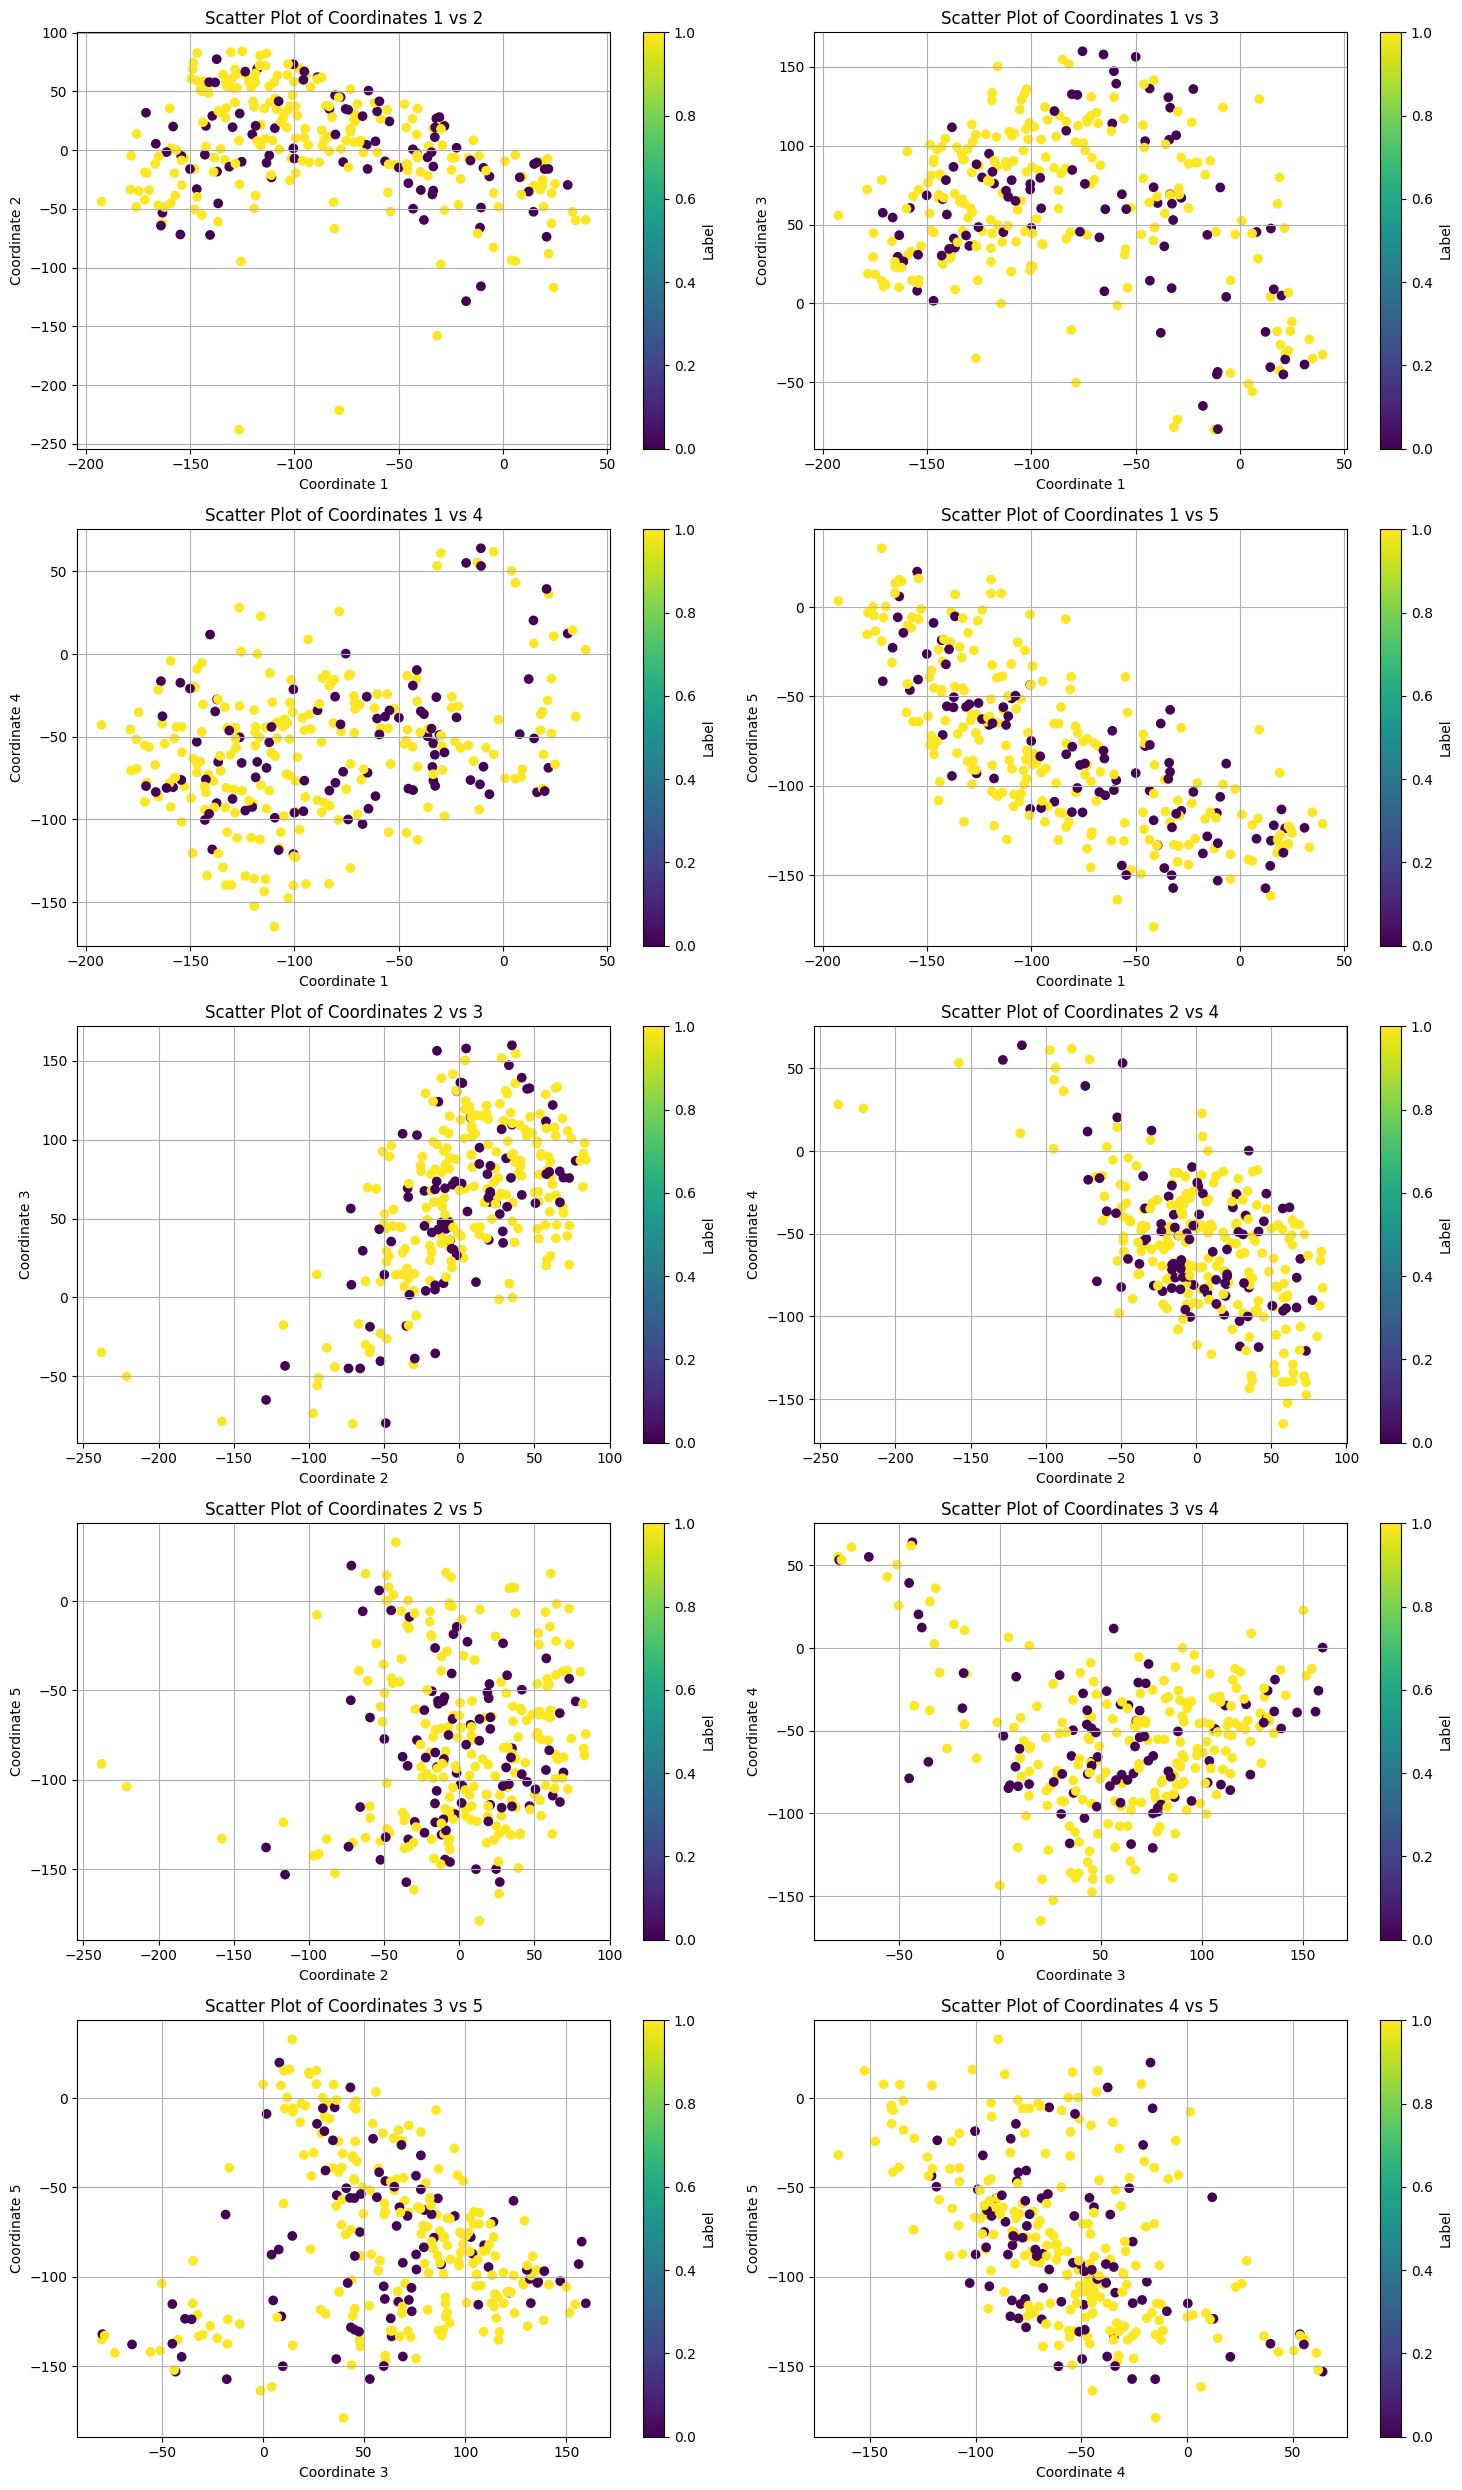

In [33]:
preds = []
labls = []
for X_batch, y_batch in test_dataloader:
    with torch.no_grad():
        preds.append(AE.encoder(X_batch).detach())
        labls += y_batch

preds = torch.cat(preds)

import itertools

# Assuming `preds` is your 5-dimensional encoded tensor
# Example: preds = torch.randn(100, 5)  # Random data for illustration

# Generate all combinations of the 5 coordinates taken 2 at a time
combos = list(itertools.combinations(range(5), 2))

# Create plots for all combinations
fig, axs = plt.subplots(5, 2, figsize=(15, 25))  # Adjust subplot grid as needed

for i, (idx1, idx2) in enumerate(combos):
    ax = axs[i//2, i%2]  # Determine the subplot for the current combo
    scatter = ax.scatter(preds[:, idx1].numpy(), preds[:, idx2].numpy(), c=kmeans.labels_, cmap='viridis')
    ax.set_title(f'Scatter Plot of Coordinates {idx1+1} vs {idx2+1}')
    ax.set_xlabel(f'Coordinate {idx1+1}')
    ax.set_ylabel(f'Coordinate {idx2+1}')
    ax.grid(True)

    cbar = fig.colorbar(scatter, ax=ax)
    cbar.set_label('Label')

plt.tight_layout()
plt.show()

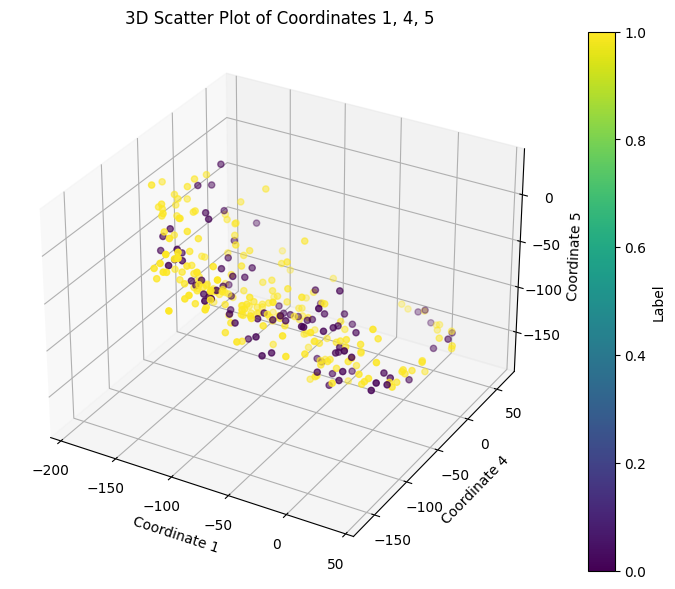

In [34]:
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Create a scatter plot
scatter = ax.scatter(preds[:, 0].numpy(), preds[:, 3].numpy(), preds[:, 4].numpy(), c=kmeans.labels_, cmap='viridis')

# Add labels and title
ax.set_xlabel('Coordinate 1')
ax.set_ylabel('Coordinate 4')
ax.set_zlabel('Coordinate 5')
ax.set_title('3D Scatter Plot of Coordinates 1, 4, 5')

# Add a color bar
cbar = fig.colorbar(scatter, ax=ax)
cbar.set_label('Label')

plt.show()

In [35]:
features

array([[3.27826857e-04, 8.94158557e-05, 1.61230386e-04, ...,
        5.67102445e-06, 5.72234663e-06, 2.96175636e-06],
       [3.26247437e-04, 1.19335501e-04, 1.47172658e-04, ...,
        5.26937846e-06, 5.17231811e-06, 3.17371014e-06],
       [3.28534117e-04, 1.15034800e-04, 1.46069436e-04, ...,
        1.97931459e-05, 1.97771267e-05, 4.15632409e-06],
       ...,
       [3.25735628e-04, 1.01520402e-04, 1.52057928e-04, ...,
        3.70694367e-06, 3.73887097e-06, 1.12846915e-06],
       [3.36175307e-04, 9.23237967e-05, 1.66581350e-04, ...,
        1.14179722e-05, 1.13581309e-05, 3.91197238e-05],
       [3.27824086e-04, 1.04686531e-04, 1.46561857e-04, ...,
        3.28094678e-05, 3.27161272e-05, 1.60410588e-05]])

In [36]:
preds2 = []
for x in features:
    with torch.no_grad():
        # Convert x from a NumPy array to a PyTorch tensor
        x_tensor = torch.tensor(x, dtype=torch.float32)
        
        # Add a batch dimension to x
        x_tensor = x_tensor.unsqueeze(0)
        preds2.append(AE.encoder(x_tensor).detach())

preds2 = torch.cat(preds2)
preds2

tensor([[-0.0977,  0.0385,  0.0449, -0.0604, -0.0118],
        [-0.0991,  0.0382,  0.0444, -0.0595, -0.0112],
        [-0.0956,  0.0381,  0.0432, -0.0603, -0.0120],
        ...,
        [-0.1008,  0.0380,  0.0436, -0.0596, -0.0106],
        [-0.0921,  0.0363,  0.0414, -0.0585, -0.0109],
        [-0.0979,  0.0360,  0.0415, -0.0573, -0.0086]])

In [37]:
encoded2 = preds2
kmeans2 = KMeans(n_clusters=2, random_state=205).fit(encoded2)
kmeans2

KMeans(n_clusters=2, random_state=205)

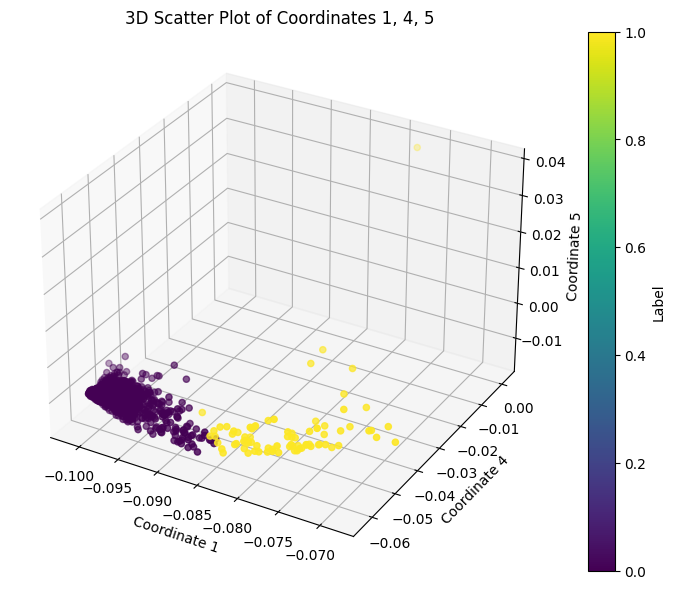

In [38]:
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Create a scatter plot
scatter = ax.scatter(preds2[:, 0].numpy(), preds2[:, 3].numpy(), preds2[:, 4].numpy(), c=kmeans2.labels_, cmap='viridis')

# Add labels and title
ax.set_xlabel('Coordinate 1')
ax.set_ylabel('Coordinate 4')
ax.set_zlabel('Coordinate 5')
ax.set_title('3D Scatter Plot of Coordinates 1, 4, 5')

# Add a color bar
cbar = fig.colorbar(scatter, ax=ax)
cbar.set_label('Label')

plt.show()

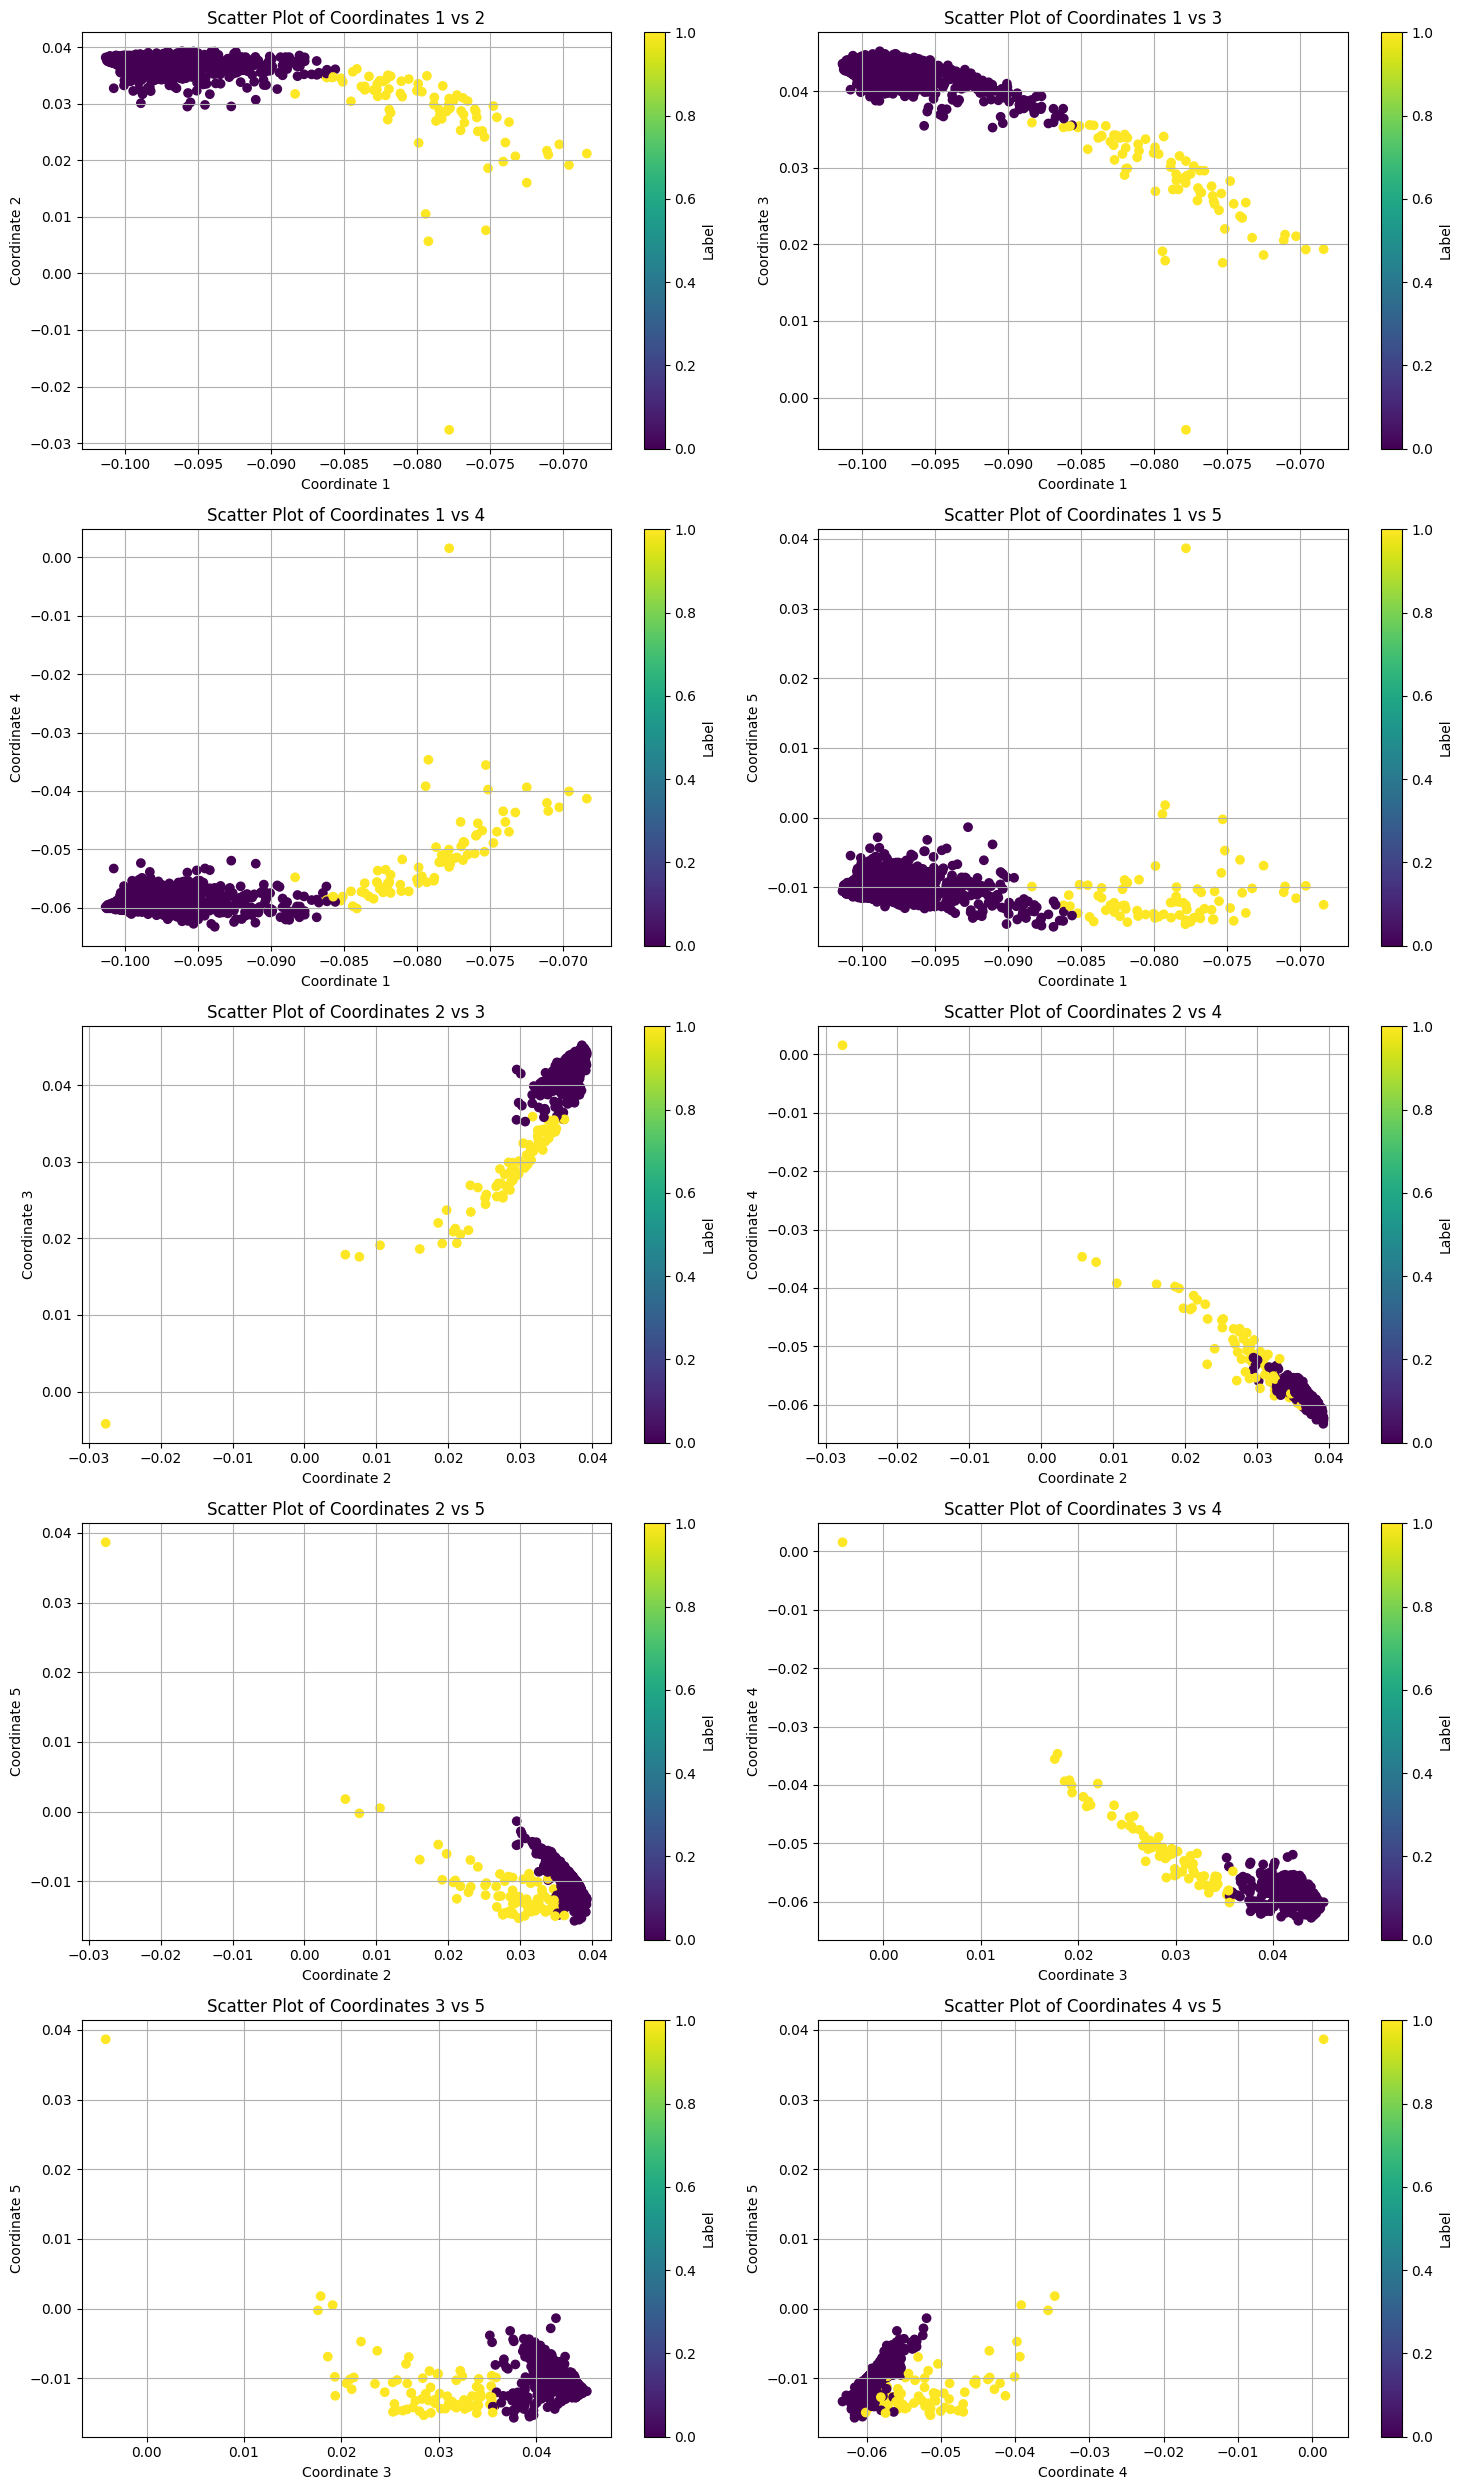

In [39]:
# Generate all combinations of the 5 coordinates taken 2 at a time
combos = list(itertools.combinations(range(5), 2))

# Create plots for all combinations
fig, axs = plt.subplots(5, 2, figsize=(15, 25))  # Adjust subplot grid as needed

for i, (idx1, idx2) in enumerate(combos):
    ax = axs[i//2, i%2]  # Determine the subplot for the current combo
    scatter = ax.scatter(preds2[:, idx1].numpy(), preds2[:, idx2].numpy(), c=kmeans2.labels_, cmap='viridis')
    ax.set_title(f'Scatter Plot of Coordinates {idx1+1} vs {idx2+1}')
    ax.set_xlabel(f'Coordinate {idx1+1}')
    ax.set_ylabel(f'Coordinate {idx2+1}')
    ax.grid(True)

    cbar = fig.colorbar(scatter, ax=ax)
    cbar.set_label('Label')

plt.tight_layout()
plt.show()

In [40]:
data_loaded = np.load(os.path.join(swift.results_path, f'SWIFT_data_{swift.res}res_{"".join(str(b) for b in swift.n_bands)}bands_DFT_True.npz'))
names_64ms, features_64ms = data_loaded['names'], data_loaded['data']

Finding Durations: 100%|███████████████████| 1423/1423 [00:22<00:00, 63.61GRB/s]


Text(0, 0.5, 'Number of GRBs')

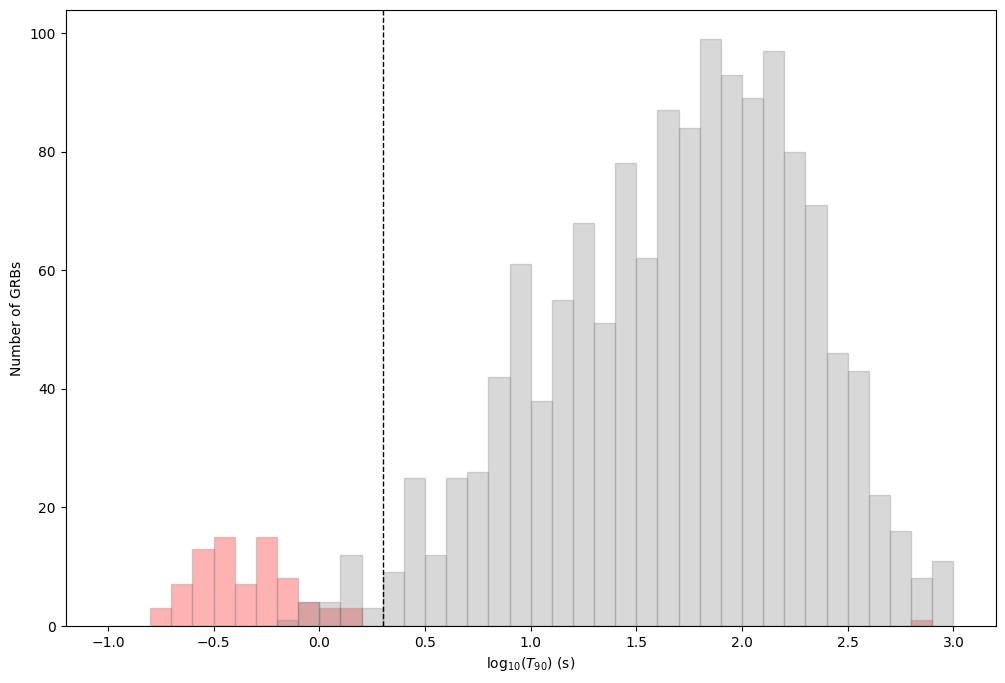

In [41]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
match = kmeans2.labels_==1
match2 = kmeans2.labels_==0
names1 = names_64ms[match]
names2 = names_64ms[match2]
swift.duration_histogram(names=[names1, names2], alpha=0.3, color_groups=['r', 'gray'], ax=ax)
ax.axvline(x=np.log10(2), c='k', ls='--', linewidth=1)
ax.set_xlabel(r'log$_{10}(T_{90})$ (s)')
ax.set_ylabel('Number of GRBs')

In [42]:
fname = f'autoencoded_{swift.res}res_{"".join(str(b) for b in swift.n_bands)}bands_DFT_True.pt'
torch.save(preds2, fname)

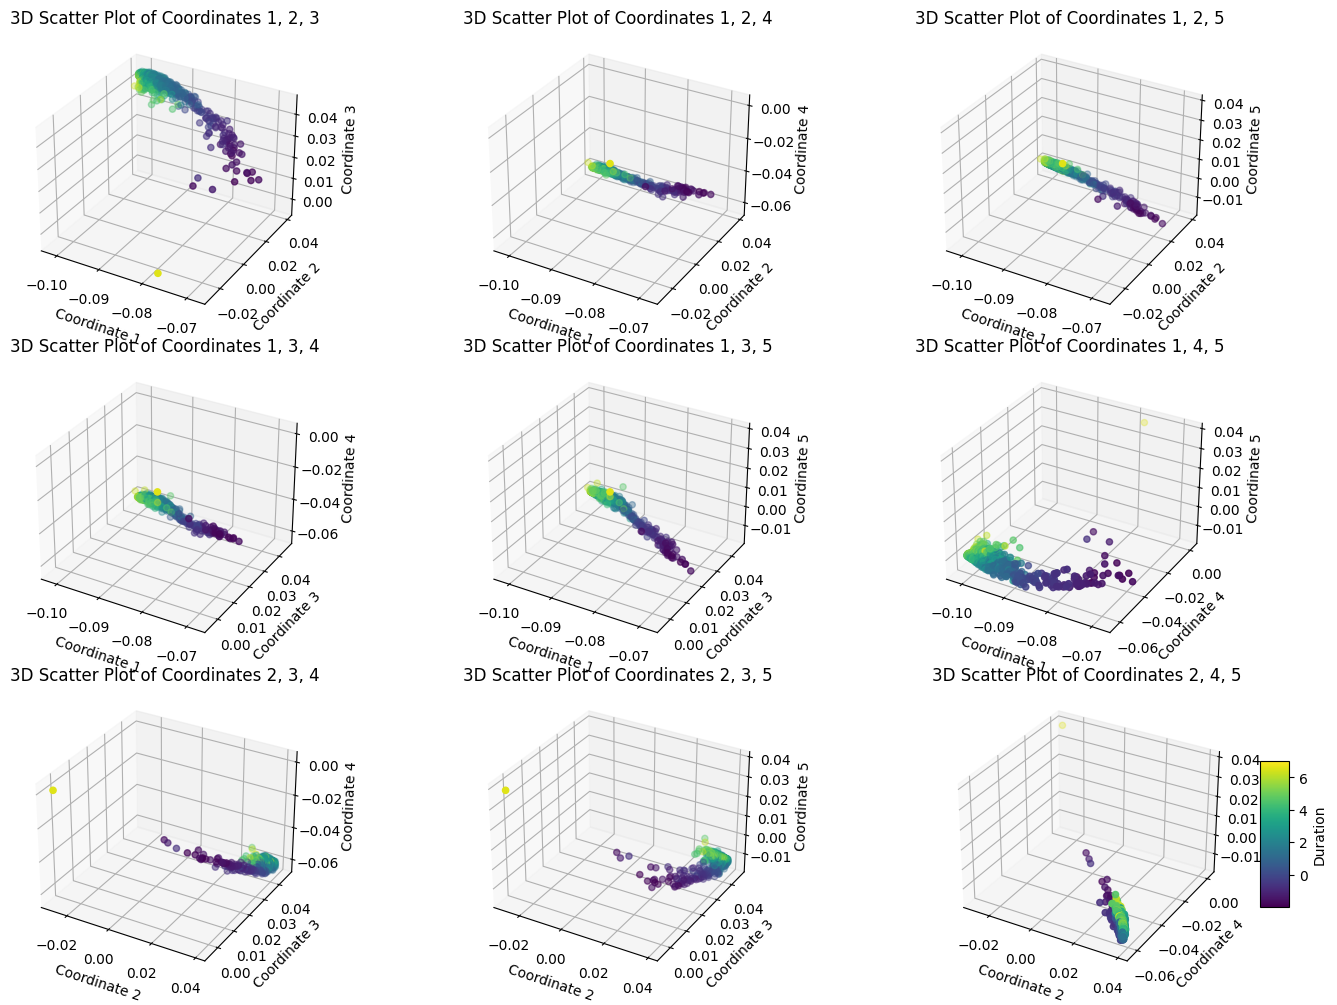

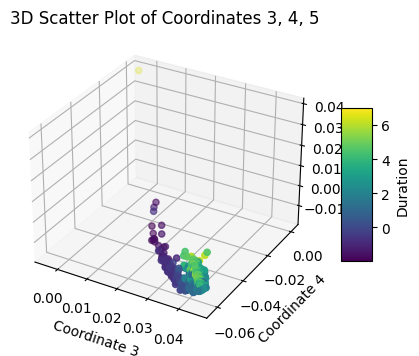

In [45]:
# Get all permutations of three columns out of five (0-based indices)
perms = list(itertools.combinations(range(5), 3))

# Function to create subplots for permutations
def create_subplots(permutations, rows, cols):
    fig_count = len(permutations) // (rows * cols) + (1 if len(permutations) % (rows * cols) > 0 else 0)
    for f in range(fig_count):
        fig = plt.figure(figsize=(15, 10))
        for i in range(1, rows * cols + 1):
            if rows * cols * f + i - 1 < len(permutations):
                x, y, z = permutations[rows * cols * f + i - 1]
                ax = fig.add_subplot(rows, cols, i, projection='3d')
                # Use durations for coloring
                scatter = ax.scatter(preds2[:, x], preds2[:, y], preds2[:, z], c=np.log(durations), cmap='viridis')
                ax.set_xlabel(f'Coordinate {x+1}')
                ax.set_ylabel(f'Coordinate {y+1}')
                ax.set_zlabel(f'Coordinate {z+1}')
                ax.set_title(f'3D Scatter Plot of Coordinates {x+1}, {y+1}, {z+1}')
        plt.colorbar(scatter, ax=ax, shrink=0.5, aspect=5, label='Duration')  # Add a colorbar with label
        plt.tight_layout()
        plt.show()

# Adjust the number of rows and columns based on how many subplots you want per figure
create_subplots(perms, 3, 3)  # Example: 9 plots per figure
